# Syntactic analysis of 10-K business descriptions for industry classifications

- POS tags, named entity recognition
- Softmax regression

Copyright 2022, Terence Lim

MIT License

In [2]:
import re
import json
import gzip
import requests
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
import spacy
from finds.database import SQL, MongoDB, Redis
from finds.structured import CRSP, Signals, Benchmarks, PSTAT
from finds.backtesting import BackTest
from finds.busday import BusDay
from finds.unstructured import Unstructured, Store
from finds.sectors import Sectoring
from finds.edgar import Edgar
from finds.display import plot_date, show
from tqdm import tqdm
from conf import VERBOSE, credentials, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = Redis(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd)
bench = Benchmarks(sql, bd)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)
item, form = 'bus10K', '10-K'
store = Store(paths['scratch'], filetype='pickle')
imgdir = paths['images'] / 'edgar'

Last FamaFrench Date 2022-11-30 00:00:00


## Retrieve and process 10-K business descriptions text

In [3]:
# Retrieve universe of stocks
univ = crsp.get_universe(20181231)

lookup = crsp.build_lookup('permno', 'comnam', fillna="")  # company name
comnam = lookup(univ.index)
univ['comnam'] = comnam

lookup_sic = pstat.build_lookup('lpermno', 'sic', fillna=0)     # sic from PSTAT
sic_ = Series(lookup_sic(univ.index, date=20181231), univ.index)
univ['siccd'] = univ['siccd'].where(sic_.isin([0, 9999]), sic_)

lookup_naics = pstat.build_lookup('lpermno', 'naics', fillna=0) # naics from PSTAT
naics_ = Series(lookup_naics(univ.index, date=20181231), univ.index)
univ['naics'] = univ['naics'].where(sic_.isin([0, 9999]), naics_)

# Retrieve business descriptions text; extract nouns from POS tags
nlp = spacy.load("en_core_web_lg")   # Load a spaCy language pipeline
if 'bus' not in store:   # store processed text if necessary
    rows = DataFrame(ed.open(form=form, item=item))  # open bus10K archive
    bus = {}
    restart = 0
    for i, permno in tqdm(enumerate(univ.index)):
        found = rows[rows['permno'].eq(permno) &
                     rows['date'].between(20190101, 20190331)]
        if len(found) and i >= restart:
            doc = nlp(ed[found.iloc[0]['pathname']][:nlp.max_length].lower())
            bus[permno] = " ".join([re.sub("[^a-zA-Z]+", "", token.lemma_)
                                    for token in doc if token.pos_ in ['NOUN']
                                    and len(token.lemma_) > 2])
    store.dump(bus, 'bus')   # serialize
bus = store.load('bus')
keys = list(bus.keys())
corpus = list(bus.values())

## Generate bag-of-words Tf-idf document features

In [4]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=10)
tfidf = vectorizer.fit_transform(corpus)
X = tfidf

## Retrieve Fama-French sector scheme

In [5]:
# populate codes49 industry, company name, and legacy sector
codes = Sectoring(sql, scheme='codes49', fillna="")     # codes49 industry
sic = Sectoring(sql, scheme='sic', fillna=0)  
codes49 = Series(codes[univ['siccd']])
replace = univ['siccd'].isin([0, 9999]).values
codes49[replace] = codes[sic[univ.loc[replace, 'naics']]]
univ['industry'] = codes49.values

codes12 = Sectoring(sql, scheme='codes12', fillna="")  # [5,10,12,17,30,38,48,49]
sic = Sectoring(sql, scheme='sic', fillna=0)    # cross-walk naics to sic
legacy = Series(codes12[univ['siccd']])         # convert sic to legacy sector
replace = (legacy.eq("").values | univ['siccd'].isin([0, 9999]).values)
legacy[replace] = codes12[sic[univ.loc[replace, 'naics']]] # convert naics
univ['legacy'] = legacy.tolist()
y = univ['legacy'].reindex(keys)
print(y.groupby(y).count().to_string())

legacy
BusEq    395
Chems     60
Durbl    110
Enrgy    117
Hlth     547
Manuf    187
Money    573
NoDur     69
Other    209
Shops    194
Telcm     46
Utils     88


## Softmax Regression with Grid CV

In [7]:
Cs = 10**(np.linspace(-4, 5, 10))
tic = time.time()
clf = LogisticRegressionCV(Cs=Cs,
                           cv=5,
                           random_state=0,
                           verbose=VERBOSE,
                           n_jobs=-1,
                           max_iter=2000).fit(X, y)
Cs = clf.Cs_  # inverse of regularization: smaller is stronger regularize

valid_accuracy = np.array(list(clf.scores_.values())[0]).mean(axis=0)
train_accuracy = []           # Train set accuracy
for C in Cs:
    clf_ =  LogisticRegression(C=C,
                               class_weight='balanced',
                               verbose=VERBOSE,
                               penalty='l2',
                               multi_class='multinomial',
                               max_iter=1000)
    clf_.fit(X, y)
    train_accuracy.append(clf_.score(X, y))

# store intermediate results    
store['logistic'] = dict(Cs=Cs, clf=clf,
                         valid_accuracy=valid_accuracy,
                         train_accuracy=train_accuracy)
res = store['logistic']

/home/terence/env3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Confusion Matrix

[[389   0   1   1   2   0   2   0   0   0   0   0]
 [  0  58   0   0   0   0   1   0   1   0   0   0]
 [  0   0 110   0   0   0   0   0   0   0   0   0]
 [  0   0   0 117   0   0   0   0   0   0   0   0]
 [  0   0   0   0 544   0   3   0   0   0   0   0]
 [  0   0   0   0   0 187   0   0   0   0   0   0]
 [  2   1   0   0   1   0 568   0   0   1   0   0]
 [  0   0   0   0   0   0   0  69   0   0   0   0]
 [  4   0   1   2   3   0   2   0 196   0   1   0]
 [  2   0   0   0   1   1   1   0   0 189   0   0]
 [  0   0   0   0   0   0   0   0   0   0  46   0]
 [  0   0   0   1   0   0   0   0   0   0   0  87]]


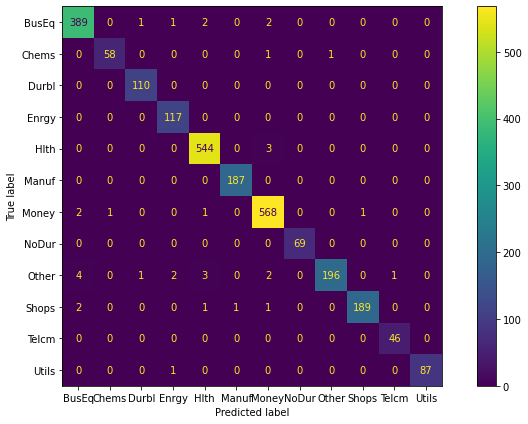

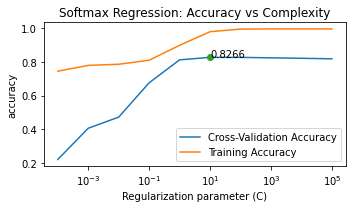

In [9]:
print(confusion_matrix(y, res.clf.predict(X)))

fig, ax = plt.subplots(figsize=(10, 6))
ConfusionMatrixDisplay.from_predictions(y, res.clf.predict(X), ax=ax)
fig.tight_layout()
plt.savefig(imgdir / 'logistic_cf.jpg')

fig, ax = plt.subplots(figsize=(5, 3))  #  accuracy vs alpha
ax.semilogx(res.Cs, res.valid_accuracy) #, drawstyle="steps-post")
ax.semilogx(res.Cs, res.train_accuracy) #, drawstyle="steps-post")
argmax = np.argmax(res.valid_accuracy)
ax.annotate(f"{res.valid_accuracy[argmax]:.4f}",
            xy=(res.Cs[argmax], res.valid_accuracy[argmax]))
ax.plot(res.Cs[argmax], res.valid_accuracy[argmax], "o")
ax.set_xlabel("Regularization parameter (C)")
ax.set_ylabel("accuracy")
ax.set_title(f"Softmax Regression: Accuracy vs Complexity")
ax.legend(['Cross-Validation Accuracy', 'Training Accuracy'])
plt.tight_layout()
plt.savefig(imgdir / 'logistic.jpg')

## Feature importances

,BusEq,Chems,Durbl,Enrgy,Hlth,Manuf,Money,NoDur,Other,Shops,Telcm,Utils
0,functionality,coating,vessel,coal,patient,steel,loan,toy,warrant,inventory,satellite,waste
1,software,chemical,vehicle,oil,device,aluminum,bank,carpet,construction,merchandise,station,utility
2,cell,fragrance,truck,refinery,candidate,backlog,insurer,apparel,rent,store,programming,glossary
3,game,additive,oem,well,therapy,tire,licensee,beverage,motor,restaurant,radio,recycling
4,semiconductor,resin,helicopter,roofing,treatment,quad,reinsurance,food,mining,dealership,carrier,gas
5,integration,lithium,appliance,rig,study,packaging,hotel,newspaper,mineral,metal,communication,water
6,founder,beauty,freight,reserve,hospital,pulp,estate,school,trial,software,subscriber,energy
7,sensor,adhesive,flight,fracturing,reimbursement,lift,premium,check,staffing,selection,spectrum,scrap
8,cloud,ams,heater,gas,drug,distributor,adviser,tobacco,client,fulfillment,cable,electricity
9,measurement,chemistry,motorcycle,liquidity,insulin,precision,agent,snack,student,gaming,television,frontier


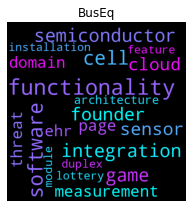

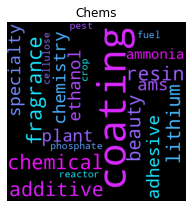

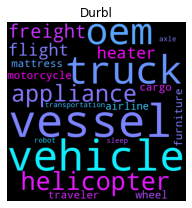

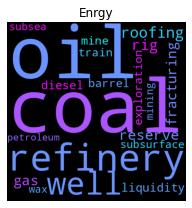

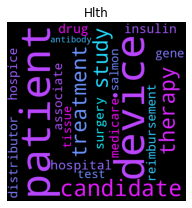

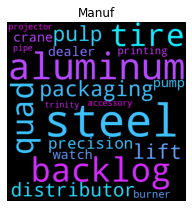

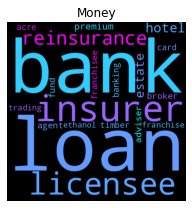

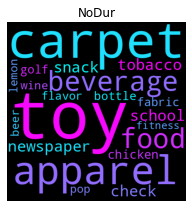

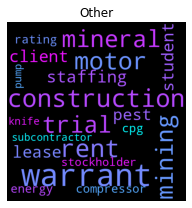

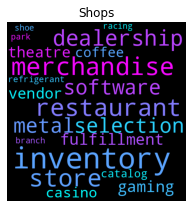

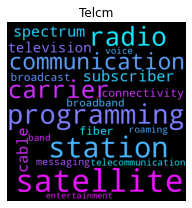

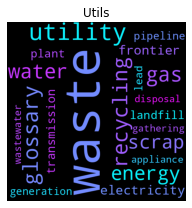

In [10]:
top_n = 20 
words = {}
feature_names = vectorizer.get_feature_names_out()
for topic, lab in enumerate(res.clf.classes_):
    importance = res.clf.coef_[topic, :]
    words[lab] = [feature_names[i]
                  for i in importance.argsort()[:-top_n-1:-1]]
    freqs = {feature_names[i]: importance[i]
             for i in importance.argsort()[:-top_n-1:-1]}
    fig, ax = plt.subplots(figsize=(3.5, 3), clear=True)
    wc = WordCloud(height=500, width=500, colormap='cool')
    ax.imshow(wc.generate_from_frequencies(freqs))
    ax.axis("off")
    ax.set_title(lab)
    plt.tight_layout()
    plt.savefig(imgdir / f"logistic_wc{topic}.jpg")
out = DataFrame.from_dict(words, orient='columns')
show(out, index=False, **SHOW)